In [1]:
#CAPSTONE PROJECT FOR EXPLORING RELATIONSHIP BETWEEN REGIGIOUS/SPIRITUAL PRACTICES ON HAPPINESS

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv("Data/WVS_Cross-National_Wave_7_csv_v6_0_2.csv", low_memory=False)

pd.set_option("display.max_columns", None)  
pd.set_option("display.max_rows", None)   
pd.set_option("display.float_format", "{:.2f}".format)  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97220 entries, 0 to 97219
Columns: 613 entries, version to v2xps_party
dtypes: float64(195), int64(406), object(12)
memory usage: 454.7+ MB


In [5]:
def explore_column_uniques(df, max_unique_display=15):
    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        num_unique = len(unique_vals)
        print(f"\n-- Column: {col}")
        print(f"Unique values count: {num_unique}")
        if num_unique <= max_unique_display:
            print(f"Unique values: {sorted(unique_vals)}")
        else:
            print(f"Too many unique values to display ({num_unique} total). Showing first {max_unique_display}:")
            print(f"{sorted(unique_vals)[:max_unique_display]}")

In [6]:
#explore_column_uniques(df)

In [7]:
# Replace missing value codes with NaN
missing_codes = [-1, -2, -3, -4, -5]
df.replace(missing_codes, pd.NA, inplace=True)

# Filter "Q" columns as these are the questions
q_columns = [col for col in df.columns if col.startswith("Q") and col[1:].isdigit()]
df = df[q_columns]

# Convert object columns to numeric (vectorized)
object_cols = df.select_dtypes(include='object').columns
df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')

#Drop non-numeric columns (already happens due to conversion, but safe to apply)
df = df.select_dtypes(include='number')

# Display summary
print(f"Final number of numeric 'Q' columns: {df.shape[1]}")

Final number of numeric 'Q' columns: 291


In [8]:
#for col in df.columns:
    #print(col)

In [9]:
#DATA CLEANING

In [10]:
#  Copy the original DataFrame
without_nan = df.copy()

#Drop columns with >20% missing values
threshold = 0.2
cols_to_drop = without_nan.columns[without_nan.isna().mean() > threshold]
clean_df = without_nan.drop(columns=cols_to_drop)

# Fill remaining NaNs with mode (safely, no inplace=True)
for col in clean_df.columns:
    if clean_df[col].isna().any():
        mode_value = clean_df[col].mode()
        if not mode_value.empty:
            clean_df[col] = clean_df[col].fillna(mode_value[0])

# Drop remaining rows with any NaNs (should be minimal now)
final_df = clean_df.dropna()

# Compare shapes and data loss
print(f"Original shape:     {df.shape}")
print(f"After column drop:  {clean_df.shape}")
print(f"Final clean shape:  {final_df.shape}")
print(f"Columns dropped:    {len(cols_to_drop)}")
print(f"Rows dropped total: {df.shape[0] - final_df.shape[0]}")

# See which columns were dropped
print("\nDropped columns (>{:.0f}% NaN):".format(threshold * 100))
print(cols_to_drop.tolist())

Original shape:     (97220, 291)
After column drop:  (97220, 277)
Final clean shape:  (97220, 277)
Columns dropped:    14
Rows dropped total: 0

Dropped columns (>20% NaN):
['Q82', 'Q85', 'Q86', 'Q89', 'Q91', 'Q92', 'Q93', 'Q223', 'Q240', 'Q276', 'Q280', 'Q282', 'Q284', 'Q293']


In [11]:
#Maintain a question mapping to enable printing of the real question.

In [12]:
question_mapping = {
    # Happiness
    'Q46': 'Overall Happiness',
    'Q46_reversed': 'Overall Happiness (Reversed: Higher = Happier)',
    'Q48': 'Freedom of Choice and Control',

    # Religious/Spirituality Attributes
    'Q164': 'Importance of God in Life',
    'Q165': 'Belief in God',
    'Q165_belief': 'Belief in God (Yes = 1, No = 0)',
    'Q166': 'Belief: Life after Death',
    'Q166_belief': 'Life is Meaningful Because God Exists (Yes = 1, No = 0)',
    'Q167': 'Belief: Heaven',
    'Q167_belief': 'Belief in Heaven (Yes = 1, No = 0)',
    'Q168': 'Belief: Hell',
    'Q168_belief': 'Belief in Hell (Yes = 1, No = 0)',
    'Q171': 'Frequency of Attending Religious Services',
    'Q171_reversed': 'Attendance at Religious Services (Reversed)',
    'Q172': 'Frequency of Prayer',
    'Q172_reversed': 'Frequency of Prayer (Reversed)',
    'Q173': 'Religious Self-Identification',
    'Q174': 'Religion Provides Meaning in Life',
    'Q175': 'Religious Faith Important for Children',

    # Health
    'Q47': 'Self-Reported Health',
    'Q47_reversed': 'Self-Reported Health (Reversed: Higher = Healthier)',

    # Financial Satisfaction
    'Q50': 'Financial Satisfaction',
    'Q51': 'Gone Without Enough Food',
    'Q51_reversed': 'Gone Without Enough Food (Reversed)',
    'Q54': 'Gone Without Cash Income',
    'Q54_reversed': 'Gone Without Cash Income (Reversed)',

    # Work and Employment
    'Q279': 'Employment Status',
    'Q281': 'Occupation Group',
    'Q286': 'Household Financial Behavior',
    'Q286_reversed': 'Family Saved Money (Reversed)',

    # Security/Crime Exposure
    'Q131': 'Feeling of Safety Walking Alone at Night',
    'Q131_reversed': 'Feeling of Security Walking Alone at Night (Reversed)',
    'Q144': 'Victim of Crime (Self)',

    # Social Capital / Trust
    'Q2' : 'Friends',
    'Q57': 'Trust: Most People',
    'Q58': 'Trust: Family',
    'Q58_reversed': 'Trust in Family (Reversed)',
    'Q59': 'Trust: Neighbors',
    'Q59_reversed': 'Trust in Neighbors (Reversed)',
    'Q60': 'Trust: Known People',
    'Q61': 'Trust: Strangers',
    'Q62': 'Trust: People of Other Religions',
    'Q63': 'Trust: People of Other Nationalities',

    # Marital Status and Children
    'Q273': 'Marital Status',
    'Q273_reversed': 'Marital Status',
    'Q274': 'Number of Children',

    # Political Freedom and Trust
    'Q250': 'Importance of Living in a Democracy',
    'Q251': 'Satisfaction with Political System',
    'Q252': 'Trust: Parliament',
    'Q253': 'Respect for Individual Human Rights',
    'Q254_reversed': 'National Pride (Reversed)',
    'Q227': 'Voters are bribed',

    # Education
    'Q275': 'Education Level',

    # Ethnicity and Discrimination
    'Q290': 'Ethnic Group Belonging',
    'Q19': 'Willing to Have as Neighbors: People of Different Race',
    'Q23': 'Willing to Have as Neighbors: Immigrants/Foreign Workers',
    'Q26': 'Willing to Have as Neighbors: People of a Different Religion',

    # Community Connection
    'Q255': 'Feeling of Belonging to City/Town',
    'Q256': 'Feeling of Belonging to Country',
    'Q257': 'Feeling of Belonging to Continent',
    'Q258': 'Feeling of Belonging to the World',
    'Q259': 'Importance of Community Belonging',

    # Relationships and Social Ties
    'Q135': 'Importance of Family',
    'Q1_reversed': 'Family Importance (Reversed)',
    'Q136': 'Importance of Friends',
    'Q138': 'Frequency of Spending Time with Family',
    'Q139': 'Frequency of Spending Time with Friends',
    'Q142': 'Satisfaction with Family Life',
    'Q143': 'Satisfaction with Friendships',
    'Q145': 'Do People Help Each Other in Your Area',
    'Q147': 'How Often Feel Lonely',
    'Q147_reversed': 'How Often Feel Lonely (Reversed)',
    'Q148': 'Number of People to Rely on in Emergency',

    # Group Membership Indicators
    'Q94': 'Member of Church or Religious Organization',
    'Q95': 'Member of Sport or Recreational Organization',
    'Q96': 'Member of Art, Music, or Educational Organization',
    'Q97': 'Member of Labor Union',
    'Q98': 'Member of Political Party',
    'Q99': 'Member of Environmental Organization',
    'Q100': 'Member of Professional Organization',
    'Q101': 'Member of Charitable Organization',
    'Q102': 'Member of Consumer Organization',
    'Q103': 'Member of Self-Help Group or Mutual Aid Society',
    'Q104': 'Member of Women’s Group',
    'Q105': 'Member of Peace Movement',
    'Q106': 'Member of Human Rights Organization',
    'Q107': 'Member of Youth Organization',
    'Q108': 'Member of Older People’s Organization',
    'Q109': 'Member of Other Organization',

    # Additional correlation items
    'Q27_reversed': 'Make Parents Proud (Reversed)',
    'Q45_reversed': 'Respect for Authority (Reversed)',
    'Q49': 'Life Satisfaction',
    'Q52_reversed': 'Gone Without Shelter (Reversed)',
    'Q53': 'Gone without medicine',
    'Q53_reversed': 'Gone Without Medicine (Reversed)',
    'Q56_reversed': 'Gone Without Necessary Clothing (Reversed)',
    'Q3': 'Leisure Time',
    'Q3_reversed': 'Leisure Time',
    'Q272': 'Language Spoken',
    'Q180': 'Cheating on Taxes',

    # Confidence in Institutions
    'Q64': 'Confidence in Churches',
    'Q64_reversed': 'Confidence in Churches (Reversed)',
    'Q69_reversed': 'Confidence in Police (Reversed)',
    'Q71_reversed': 'Confidence in Government (Reversed)',
    'Q72': 'Confidence in Political Parties',
    'Q72_reversed': 'Confidence in Political Parties (Reversed)',
    'Q73': 'Confidence in Parliament',
    'Q73_reversed': 'Confidence in Parliament (Reversed)',
    'Q74': 'Confidence in Civil Service',
    'Q74_reversed': 'Confidence in Civil Service (Reversed)',
    'Q75': 'Confidence in Universities',
    'Q75_reversed': 'Confidence in Universities (Reversed)',
    'Q76_reversed': 'Confidence in Elections (Reversed)',
    'Q77': 'Confidence in Major Companies',
    'Q77_reversed': 'Confidence in Major Companies (Reversed)',
    'Q78': 'Confidence in Banks',
    'Q78_reversed': 'Confidence in Banks (Reversed)',
    'Q79': 'Confidence in Environmental Organizations',
    'Q79_reversed': 'Confidence in Environmental Organizations (Reversed)',
    'Q80': 'Confidence in Women’s Organizations',
    'Q80_reversed': 'Confidence in Women’s Organizations (Reversed)',
    'Q81': 'Confidence in Charitable/Humanitarian Organizations',
    'Q81_reversed': 'Confidence in Charitable/Humanitarian Organizations (Reversed)',

    # Social Class and Income
    'Q287_reversed': 'Self-Described Social Class (Upper Class is Higher - Reversed)',
    'Q288': 'Perceived Household Income Group'
}


In [13]:
#PREPARE THE DATA SO ALL VALUES ARE IN INCREASING ORDER OF THEIR IMPACT to HAPPINESS.

In [14]:
def prepare_data(df):
    df = df.copy()  # Ensure we're not modifying the original input

    def reverse_column(original, max_val):
        reversed_col = f"{original}_reversed"
        if reversed_col not in df.columns:
            df.loc[:, reversed_col] = max_val + 1 - df[original]

    # Questions with values 1–4 that need reversal
    reverse_1_to_4 = [
        'Q1', 'Q3', 'Q71','Q27','Q76','Q69','Q45',
        'Q46', 'Q56', 'Q58', 'Q59',
        'Q64', 'Q72', 'Q73', 'Q74', 'Q75', 'Q77', 'Q78', 'Q79', 'Q80', 'Q81',
        'Q131', 'Q147','Q253','Q286'
    ]
    for col in reverse_1_to_4:
        if col in df.columns:
            df = df[df[col].between(1, 4)].copy()
            reverse_column(col, 4)

    # Questions with values 1–10 (no reversal)
    for col in ['Q48', 'Q49', 'Q50']:
        if col in df.columns:
            df = df[df[col].between(1, 10)].copy()

    # Single reversals with custom max value
    single_reversals = {
        'Q47': 5,
        'Q287': 5,
        'Q254': 5,
        'Q171': 7,
        'Q172': 8,
        'Q273' : 6
    }
    for col, max_val in single_reversals.items():
        if col in df.columns:
            df = df[df[col].between(1, max_val)].copy()
            reverse_column(col, max_val)

    return df


In [15]:
ordered_df = prepare_data(final_df)

In [16]:
print(f"Final number of numeric 'Q' columns: {ordered_df.shape[1]}")
print(ordered_df.dtypes.head())

Final number of numeric 'Q' columns: 308
Q1    float64
Q2    float64
Q3    float64
Q4    float64
Q5    float64
dtype: object


In [17]:
# Drop original columns that have a _reversed counterpart
prepared_df = prepare_data(final_df)
reversed_cols = [col for col in prepared_df.columns if col.endswith('_reversed')]
original_cols = [col.replace('_reversed', '') for col in reversed_cols]

# Only drop the originals if they exist (to avoid duplicates)
cols_to_drop = [col for col in original_cols if col in prepared_df.columns]
prepared_df = prepared_df.drop(columns=cols_to_drop)

print(f"Final Shape: {prepared_df.shape}")
print(prepared_df.dtypes.head())

Final Shape: (97220, 277)
Q2    float64
Q4    float64
Q5    float64
Q6    float64
Q7    float64
dtype: object


In [18]:
#DATA CLEANING AND PREPARATION COMPLETED, NOW ANALALYING CORRELATION

In [19]:
# Get correlations
correlations = prepared_df.corr(numeric_only=True)['Q46_reversed'].sort_values(key=abs, ascending=False)

# Display top 30 correlations with question labels
print("\nTop 30 correlations with Q46 (Happiness):\n")
for question_code, corr_value in correlations.head(30).items():
    question_text = question_mapping.get(question_code, f"Unknown ({question_code})")
    print(f"{question_code: <15} | {corr_value:>5.2f} | {question_text}")


Top 30 correlations with Q46 (Happiness):

Q46_reversed    |  1.00 | Overall Happiness (Reversed: Higher = Happier)
Q49             |  0.44 | Life Satisfaction
Q47_reversed    |  0.37 | Self-Reported Health (Reversed: Higher = Healthier)
Q50             |  0.34 | Financial Satisfaction
Q48             |  0.24 | Freedom of Choice and Control
Q131_reversed   |  0.19 | Feeling of Security Walking Alone at Night (Reversed)
Q254_reversed   |  0.15 | National Pride (Reversed)
Q288            |  0.14 | Perceived Household Income Group
Q287_reversed   |  0.14 | Self-Described Social Class (Upper Class is Higher - Reversed)
Q54             |  0.14 | Gone Without Cash Income
Q253_reversed   |  0.14 | Unknown (Q253_reversed)
Q58_reversed    |  0.13 | Trust in Family (Reversed)
Q53             |  0.13 | Gone without medicine
Q71_reversed    |  0.13 | Confidence in Government (Reversed)
Q78_reversed    |  0.13 | Confidence in Banks (Reversed)
Q75_reversed    |  0.12 | Confidence in Universities (R

In [20]:
#PRINT THE CORRELATION MATRIX

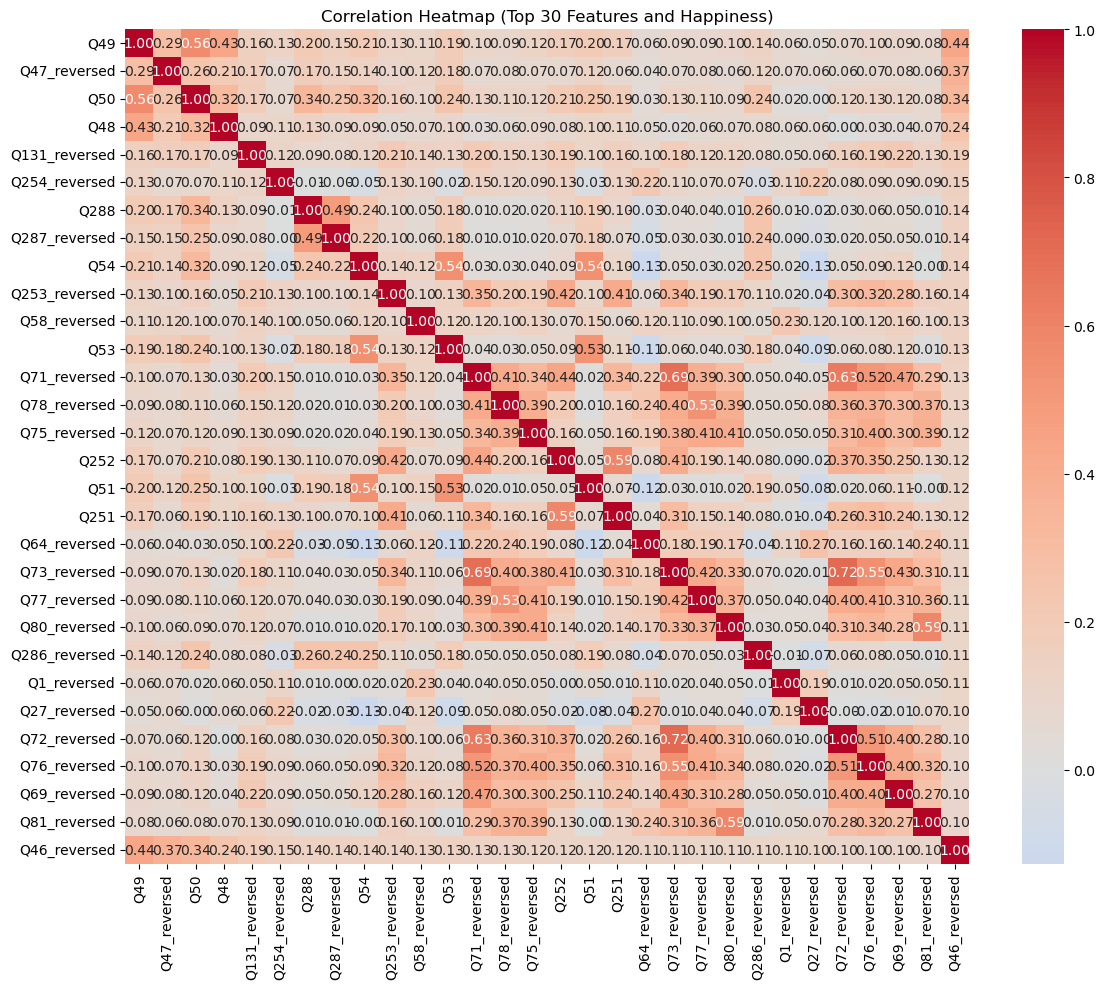

In [21]:
top_features = correlations.head(30).index.drop('Q46_reversed')

corr_matrix = prepared_df[top_features.tolist() + ['Q46_reversed']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Top 30 Features and Happiness)")
plt.tight_layout()
plt.show()

In [22]:
#PLOT THE FEATURE TO HAPPINESS BOX PLOTS

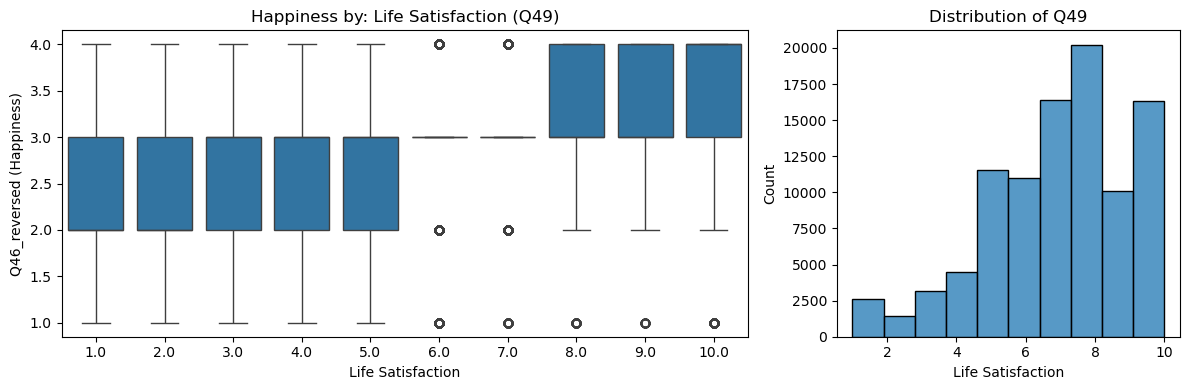

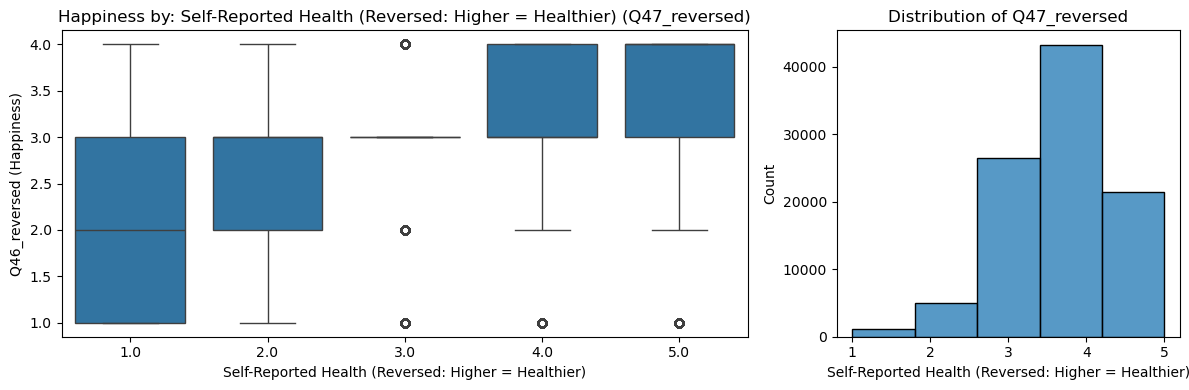

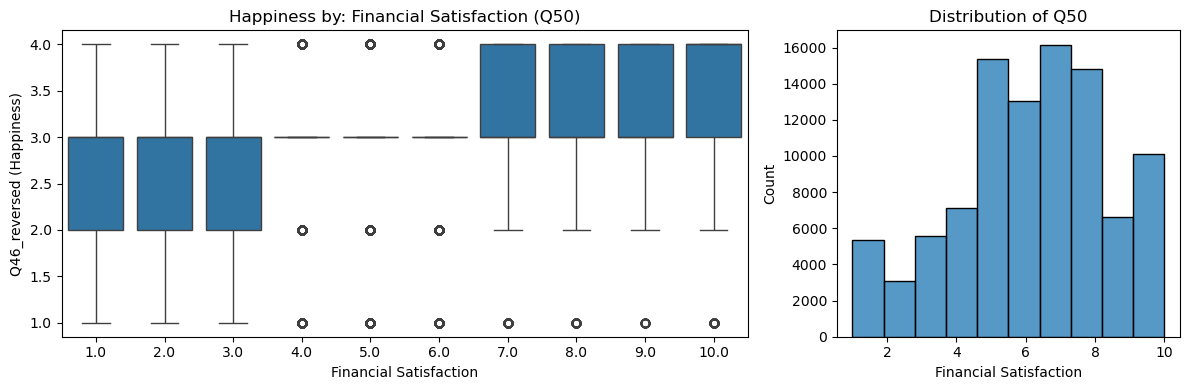

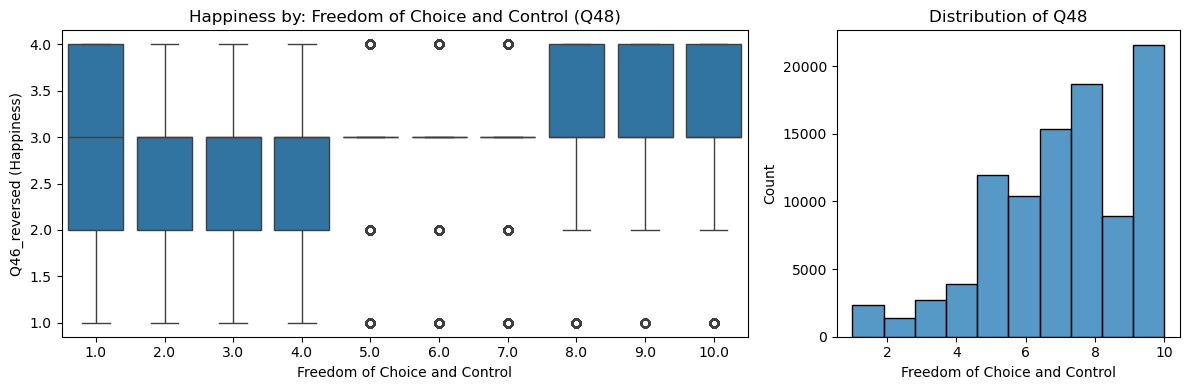

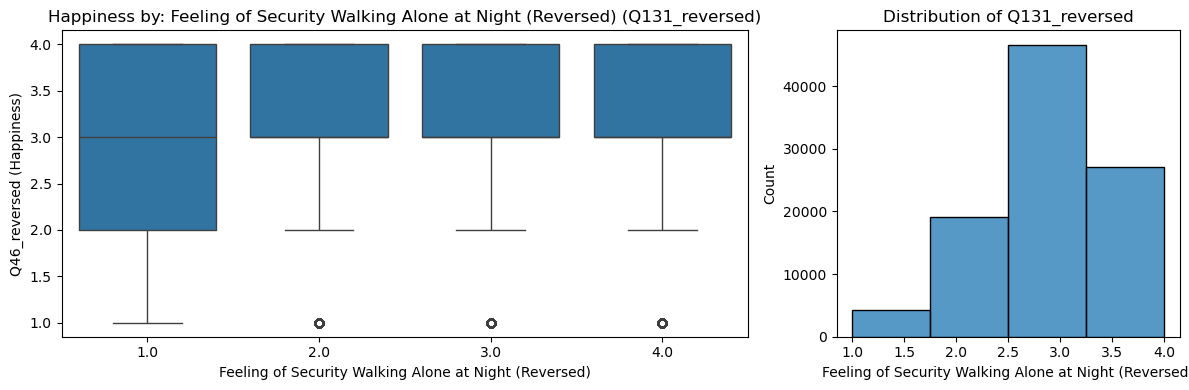

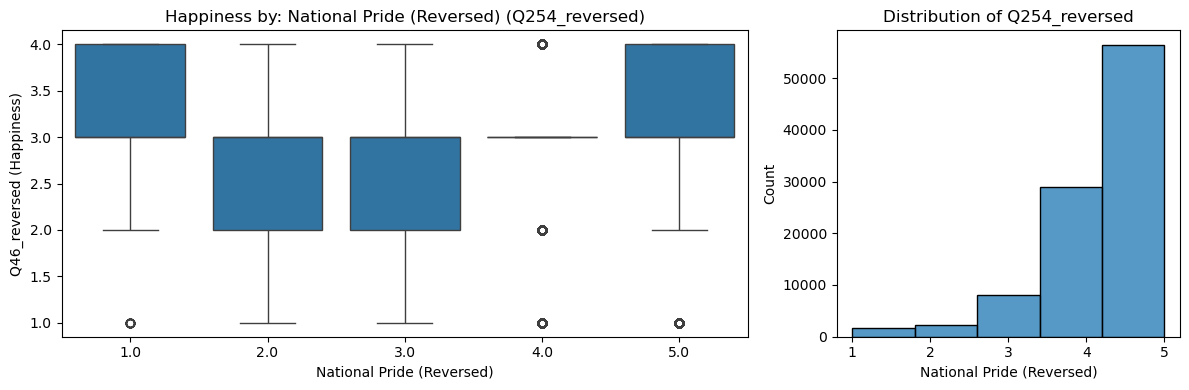

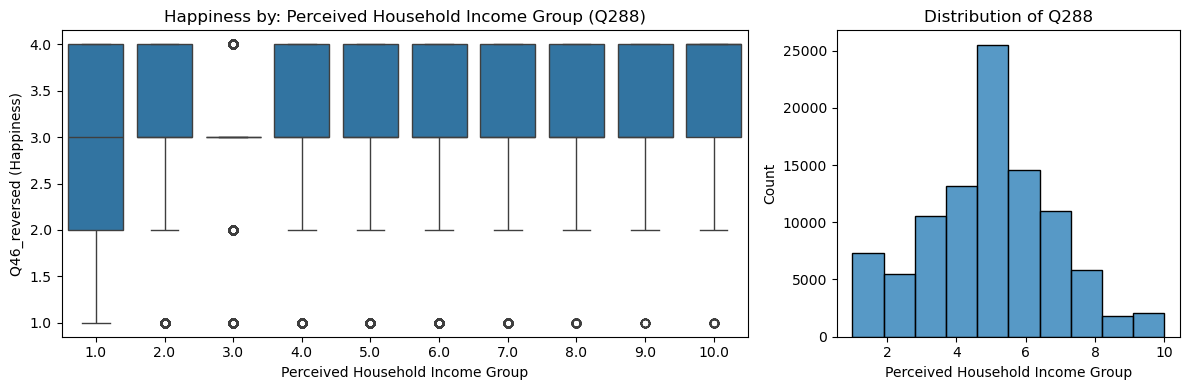

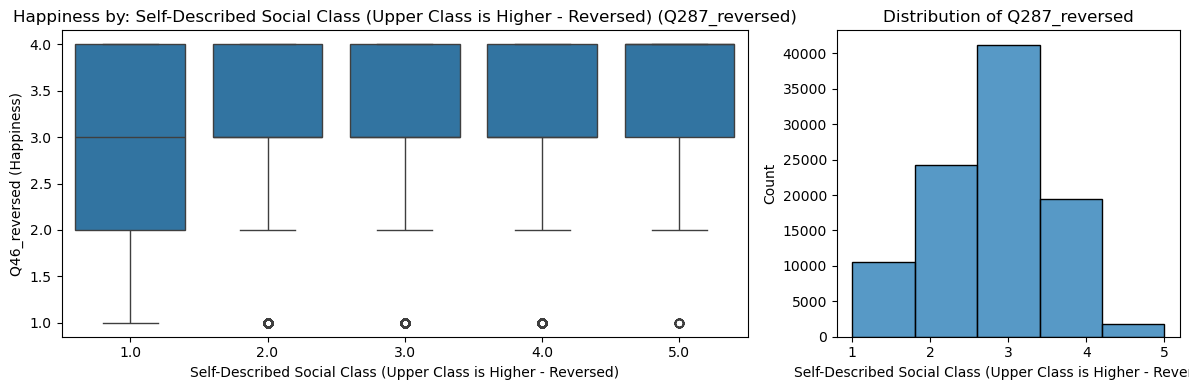

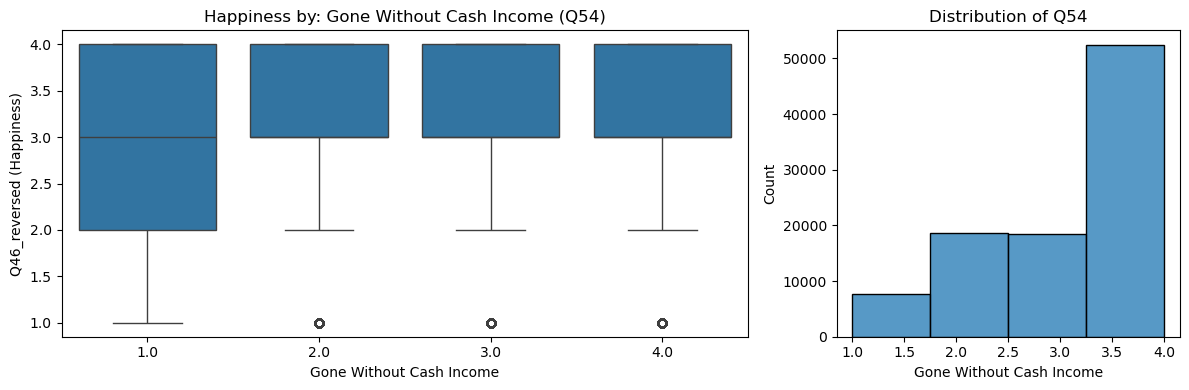

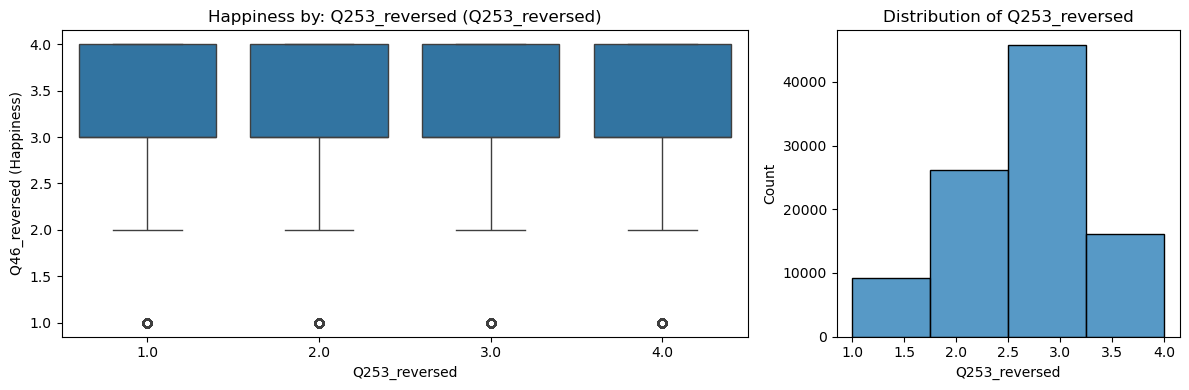

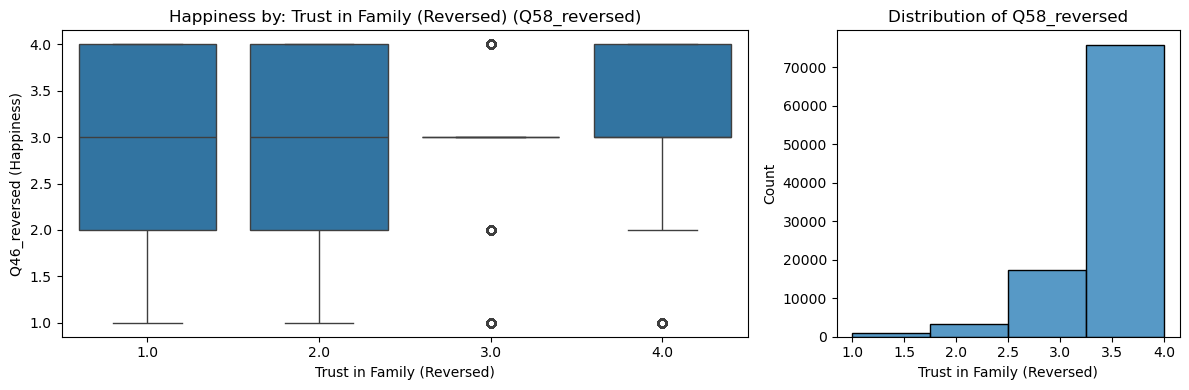

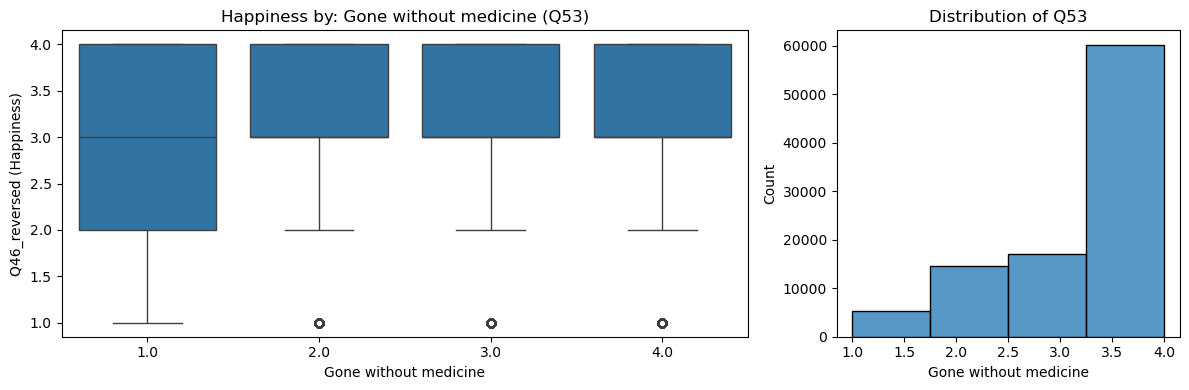

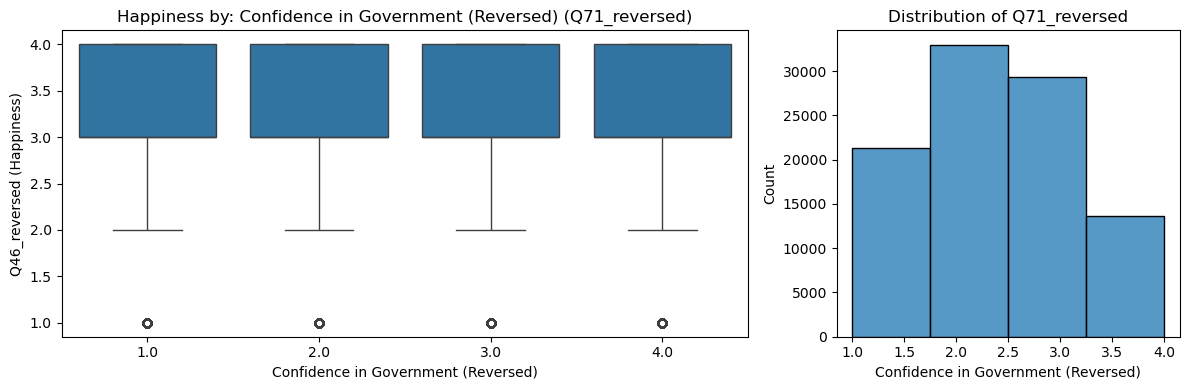

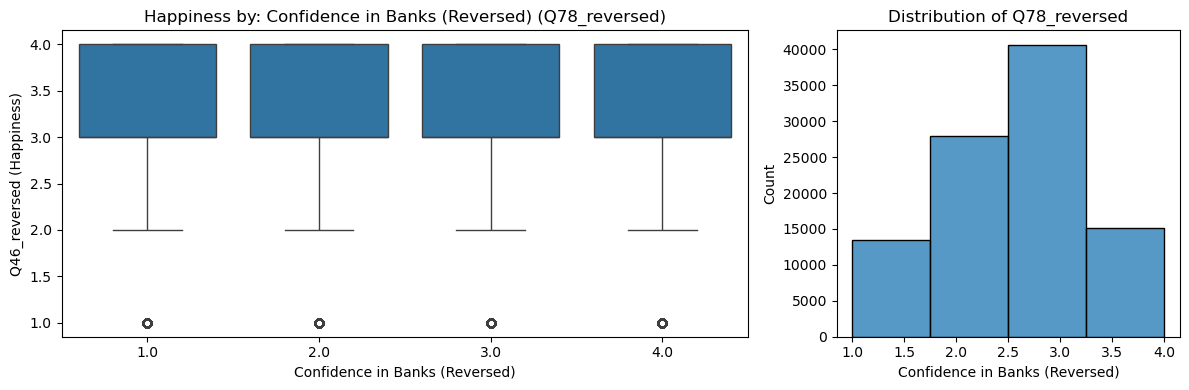

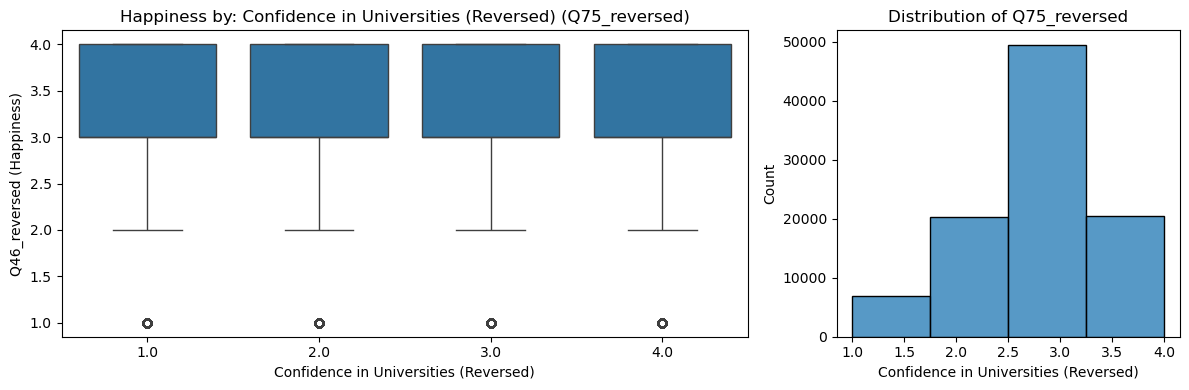

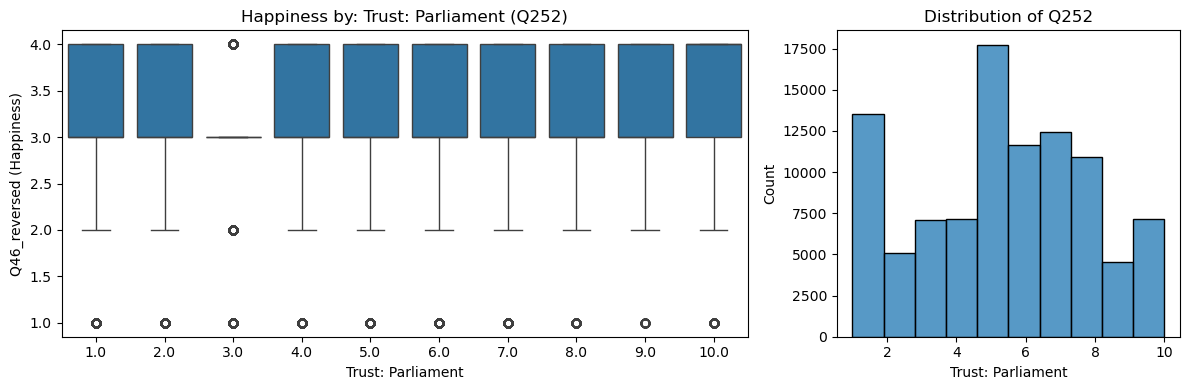

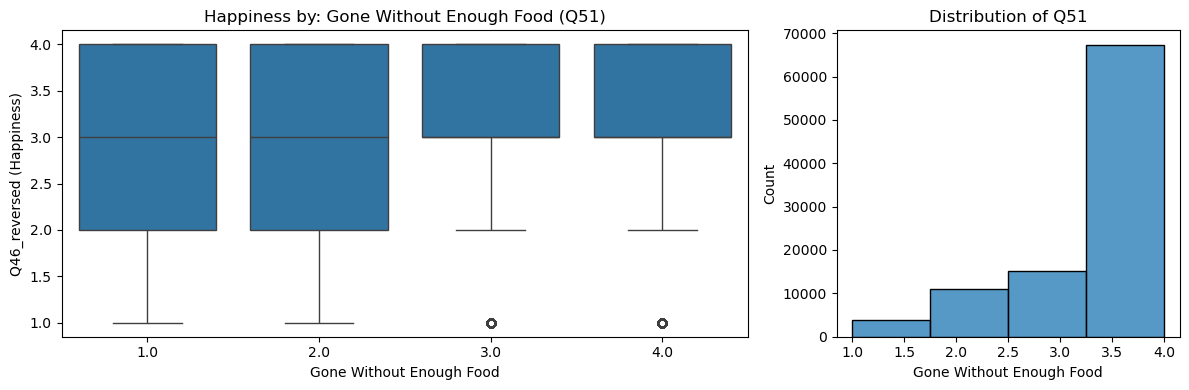

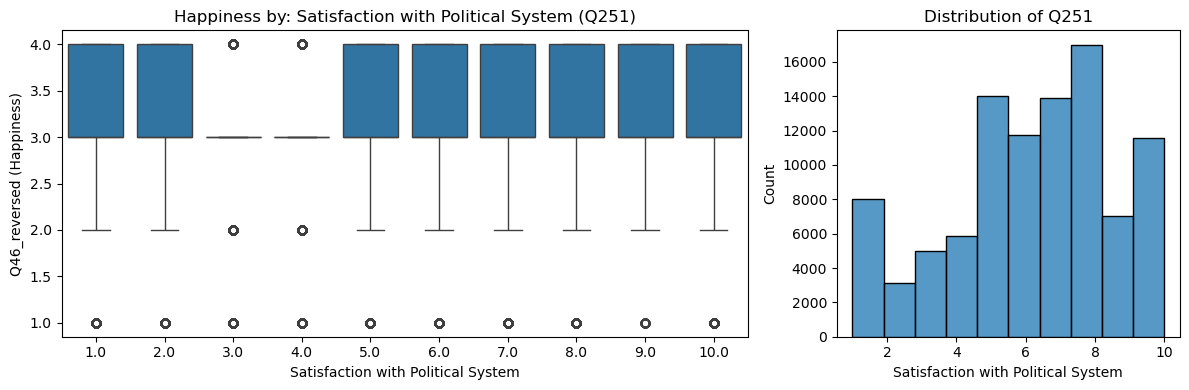

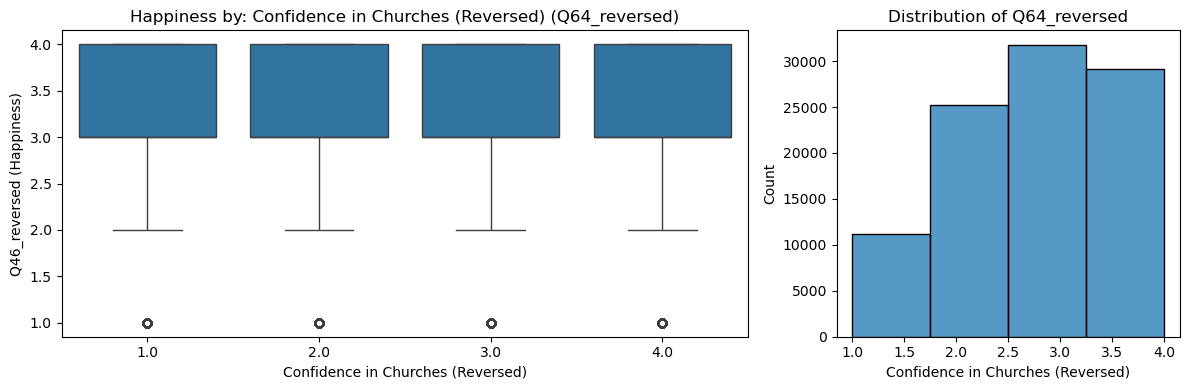

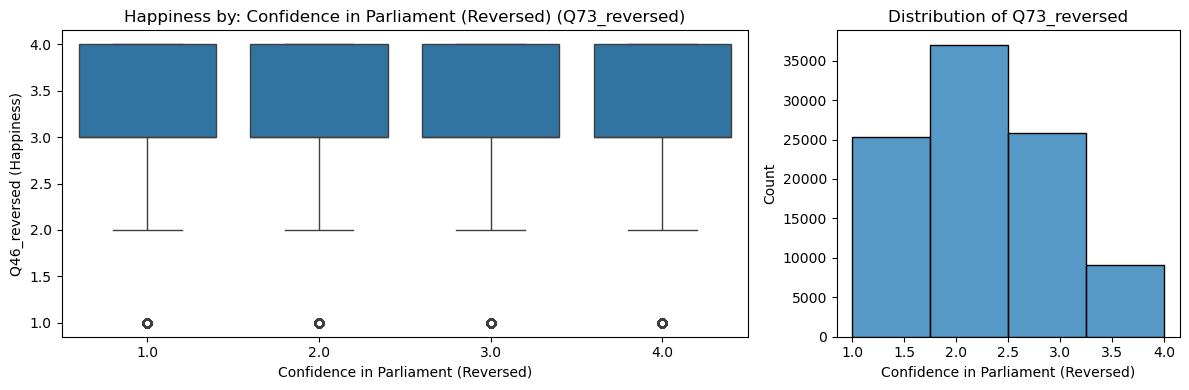

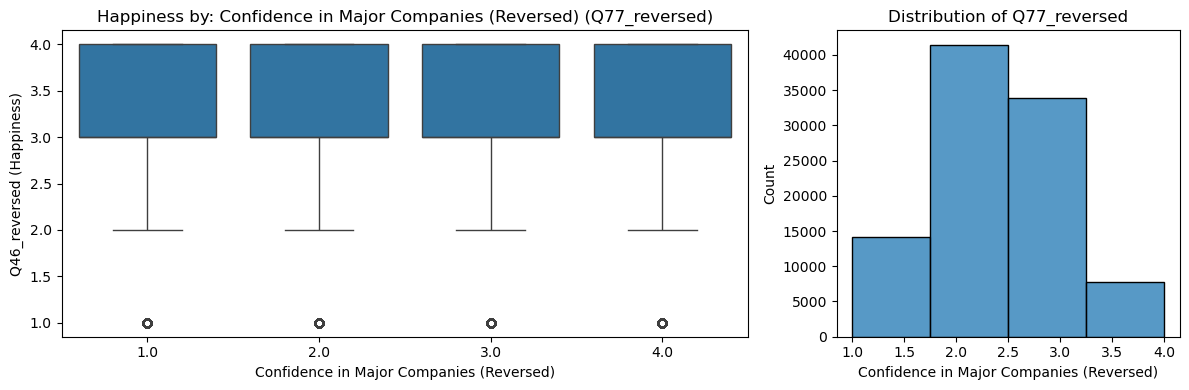

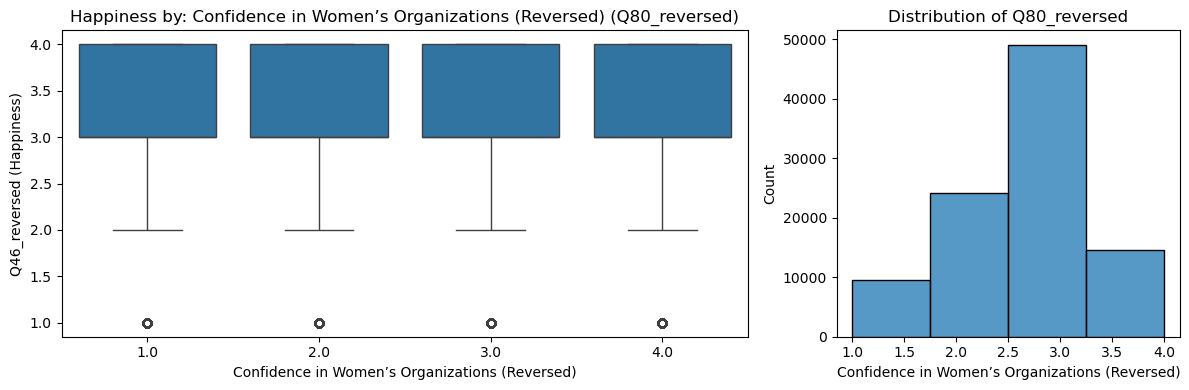

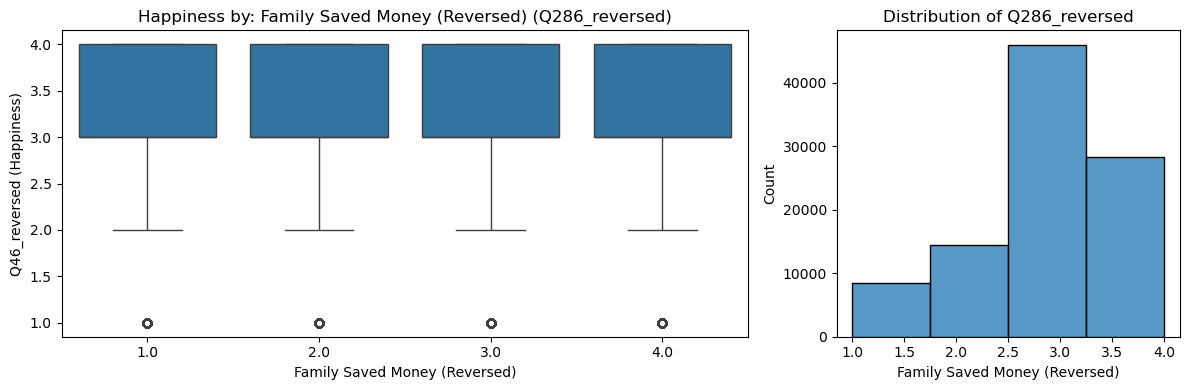

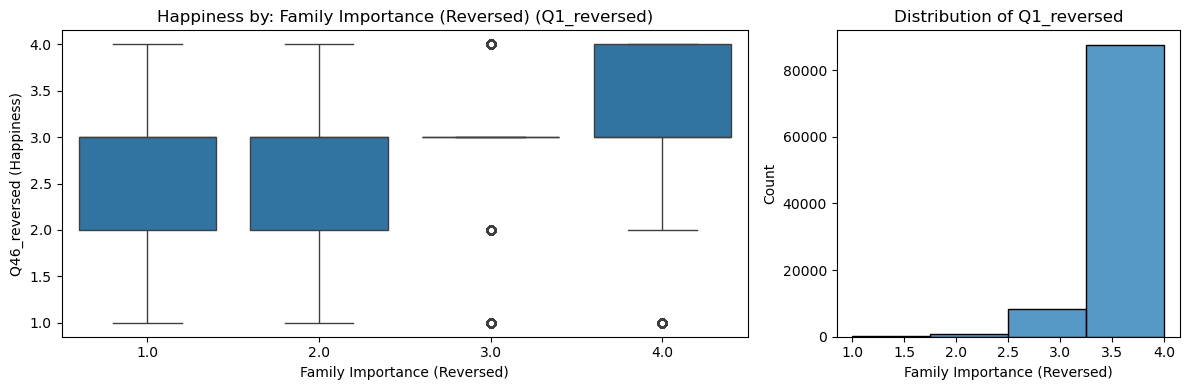

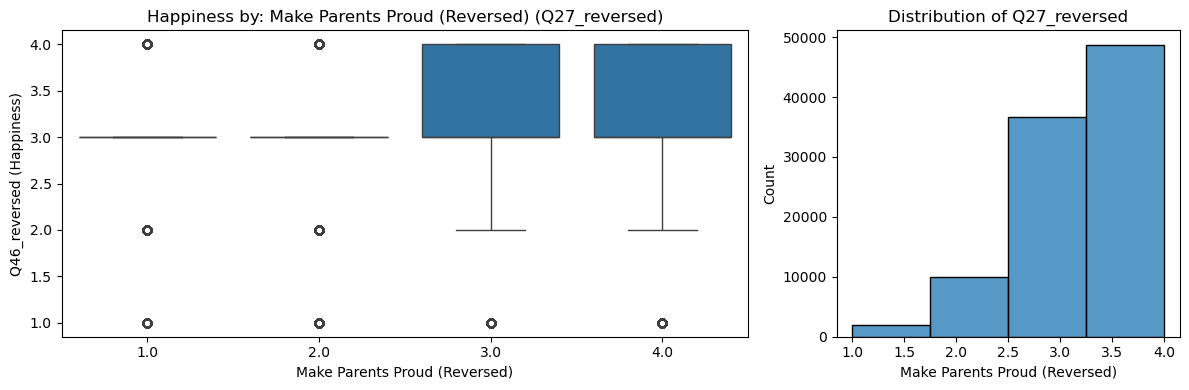

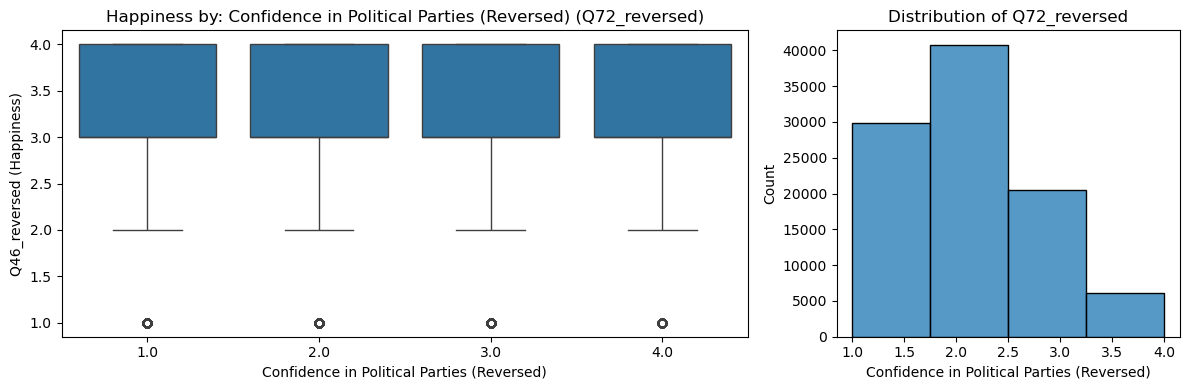

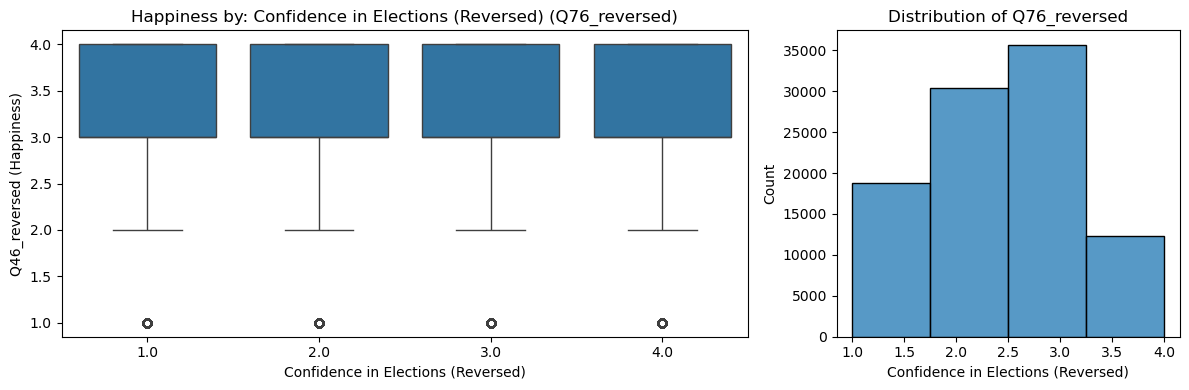

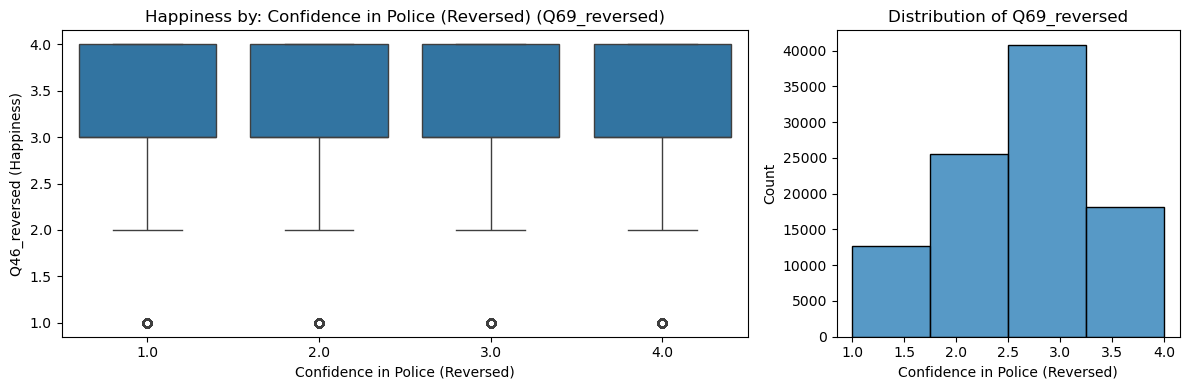

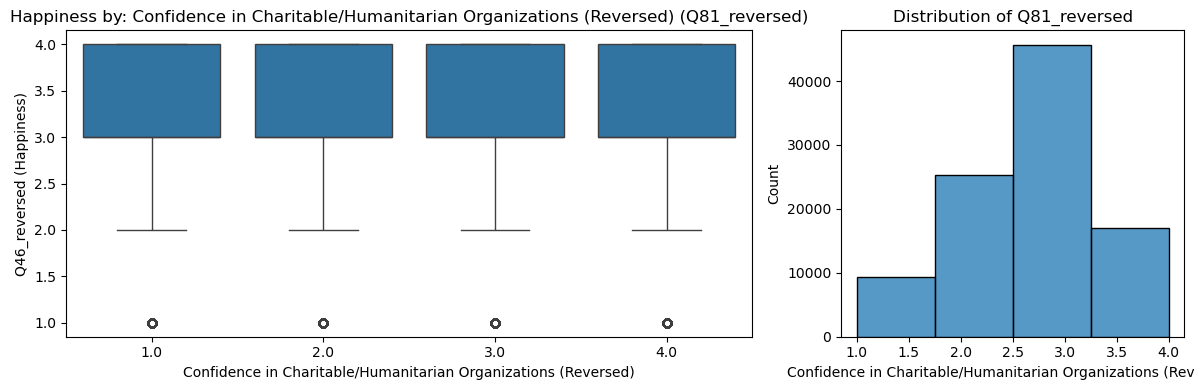

In [23]:
top_features = correlations.head(30).index.drop('Q46_reversed')

for col in top_features:
    question_text = question_mapping.get(col, col)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Boxplot
    sns.boxplot(x=prepared_df[col], y=prepared_df['Q46_reversed'], ax=axes[0])
    axes[0].set_title(f'Happiness by: {question_text} ({col})')
    axes[0].set_xlabel(question_text)
    axes[0].set_ylabel('Q46_reversed (Happiness)')

    # Right: Histogram
    sns.histplot(prepared_df[col], kde=False, bins=len(prepared_df[col].unique()), ax=axes[1])
    axes[1].set_title(f'Distribution of {col}')
    axes[1].set_xlabel(question_text)
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


In [24]:
#LINEAR REGRESSSION

In [25]:
# Copy the original DataFrame
without_nan = prepared_df.copy()

# Drop columns with >30% missing values
threshold = 0.3
cols_to_drop = without_nan.columns[without_nan.isna().mean() > threshold]
clean2_df = without_nan.drop(columns=cols_to_drop)

# Fill remaining NaNs with mode (safely, no inplace=True)
for col in clean_df.columns:
    if clean_df[col].isna().any():
        mode_value = clean_df[col].mode()
        if not mode_value.empty:
            clean_df[col] = clean_df[col].fillna(mode_value[0])

# Drop remaining rows with any NaNs (should be minimal now)
final2_df = clean_df.dropna()

# Compare shapes and data loss
print(f"Original shape:     {prepared_df.shape}")
print(f"After column drop:  {clean_df.shape}")
print(f"Final clean shape:  {final_df.shape}")
print(f"Columns dropped:    {len(cols_to_drop)}")
print(f"Rows dropped total: {prepared_df.shape[0] - final2_df.shape[0]}")

print("\nDropped columns (>{:.0f}% NaN):".format(threshold * 100))
print(cols_to_drop.tolist())


Original shape:     (97220, 277)
After column drop:  (97220, 277)
Final clean shape:  (97220, 277)
Columns dropped:    0
Rows dropped total: 0

Dropped columns (>30% NaN):
[]


In [26]:
def drop_column_if_exists(df, col_name):
    if col_name in df.columns:
        df = df.drop(columns=[col_name])
        print(f"Column '{col_name}' dropped.")
    else:
        print(f"Column '{col_name}' not found. Nothing to drop.")
    return df

# Drop Life Satisfaction as it a proxy/another variation to Hapiness Question and also show high correlation
prepared_df = drop_column_if_exists(prepared_df, 'Q49')

Column 'Q49' dropped.


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

y = prepared_df['Q46_reversed']
X = prepared_df.drop(columns=['Q46_reversed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

coeffs = pd.Series(lr_model.coef_, index=X.columns)
coeffs_named = coeffs.rename(index=question_mapping).sort_values(key=np.abs, ascending=False)

print(coeffs_named.head(10))


Mean Squared Error: 0.352
R² Score: 0.286
Self-Reported Health (Reversed: Higher = Healthier)              0.18
Financial Satisfaction                                           0.12
Freedom of Choice and Control                                    0.06
Feeling of Security Walking Alone at Night (Reversed)            0.05
National Pride (Reversed)                                        0.04
Marital Status                                                   0.03
Trust in Family (Reversed)                                       0.03
Self-Described Social Class (Upper Class is Higher - Reversed)   0.02
Leisure Time                                                     0.02
Family Importance (Reversed)                                     0.02
dtype: float64


In [28]:
#Group Health ,Finance, Security  to see if people with similar haelth and finance would report more hapiness with religous or spirtual practices

In [29]:
grouping_df = prepared_df.copy()

# Define core domains
domains = {
    'health': ['Q47_reversed'],
    'finance': ['Q50', 'Q51_reversed', 'Q54_reversed'],
    'security': ['Q131_reversed','Q144'],
    'national_pride': ['Q254_reversed'],
    'marital_status':['Q273_reversed'],      
    'religion': ['Q164', 'Q165_belief', 'Q166_belief', 'Q167_belief', 'Q168_belief',
                 'Q171_reversed', 'Q172_reversed', 'Q173', 'Q174', 'Q175'],
    'happiness': ['Q46_reversed']
}

# Compute scores
for domain, cols in domains.items():
    valid_cols = [col for col in cols if col in grouping_df.columns]
    grouping_df[f'{domain}_score'] = grouping_df[valid_cols].mean(axis=1)

In [30]:


X_cluster = grouping_df[['health_score', 'finance_score']]
kmeans = KMeans(n_clusters=5, random_state=42)
grouping_df['health_finance_group'] = kmeans.fit_predict(X_cluster)

In [31]:
results = []

for group_id in sorted(grouping_df['health_finance_group'].unique()):
    subset = grouping_df[grouping_df['health_finance_group'] == group_id]
    
    X = subset[['religion_score']]
    y = subset['happiness_score']  # or 'Q46_reversed'
    
    if len(subset) > 30:  # skip very small groups
        model = LinearRegression()
        model.fit(X, y)
        r2 = model.score(X, y)
        coef = model.coef_[0]
        results.append((group_id, len(subset), coef, r2))

In [32]:
results_df = pd.DataFrame(results, columns=['Group', 'Size', 'Religion_Coefficient', 'R2_Score'])
print(results_df.sort_values(by='R2_Score', ascending=False))

   Group   Size  Religion_Coefficient  R2_Score
4      4  29177                  0.05      0.01
1      1   4532                  0.08      0.01
2      2  22345                  0.06      0.01
0      0  31579                  0.05      0.01
3      3   9587                  0.05      0.00


In [33]:
#Overall check if regligious or spirtual practices make any difference

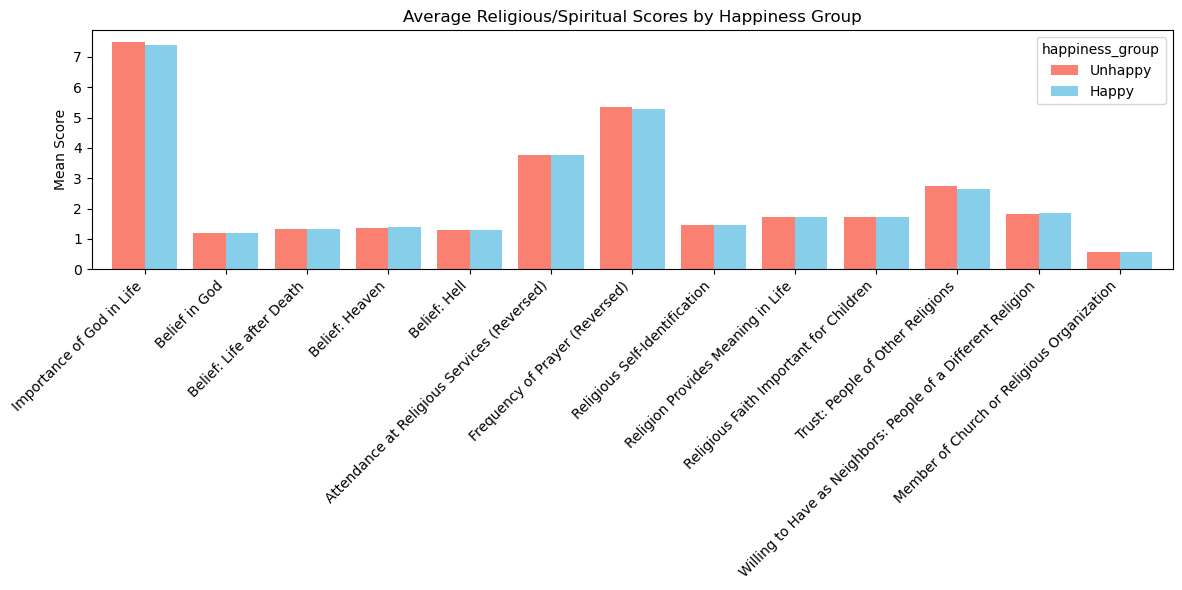

In [34]:
# Copy the dataset
happy_df = prepared_df.copy()

# Define happiness variable
happiness_col = 'Q46_reversed' if 'Q46_reversed' in happy_df.columns else 'Q46'

# Create happiness group
happy_df['happiness_group'] = pd.cut(
    happy_df[happiness_col],
    bins=[0, 2, 4],  # 1-2 = Unhappy, 3-4 = Happy
    labels=['Unhappy', 'Happy']
)

# Get only religion-related questions based on keywords
keywords = ['religion', 'religious', 'belief', 'god', 'prayer', 'faith']
religion_vars = [q for q, desc in question_mapping.items()
                 if any(k in desc.lower() for k in keywords) and q in happy_df.columns]

# Compute mean values by happiness group
means = happy_df.groupby('happiness_group', observed=True)[religion_vars].mean().T

# Rename rows to meaningful names
means.index = means.index.map(lambda x: question_mapping.get(x, x))

# Plot
means.plot(kind='bar', figsize=(12, 6), width=0.8, color=['salmon', 'skyblue'])
plt.title('Average Religious/Spiritual Scores by Happiness Group')
plt.ylabel('Mean Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
#The above plots and data show very little influence of religion or spiritual practices on happy/unhappy data groupings.

In [36]:
#Prepare data for Classification

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# Create Binary Target
y_binary = prepared_df['Q46_reversed'].replace({1: 'Unhappy', 2: 'Unhappy', 3: 'Happy', 4: 'Happy'})

#  Define Features (drop target)
X = prepared_df.drop(columns=['Q46_reversed','Q261']) # date of birth as age exists

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [38]:
print(X.shape)

(97220, 274)


In [39]:
#DECISION TREE

Accuracy: 0.8690084344785024

Classification Report:
               precision    recall  f1-score   support

       Happy       0.88      0.98      0.93     16705
     Unhappy       0.62      0.18      0.28      2739

    accuracy                           0.87     19444
   macro avg       0.75      0.58      0.60     19444
weighted avg       0.84      0.87      0.84     19444



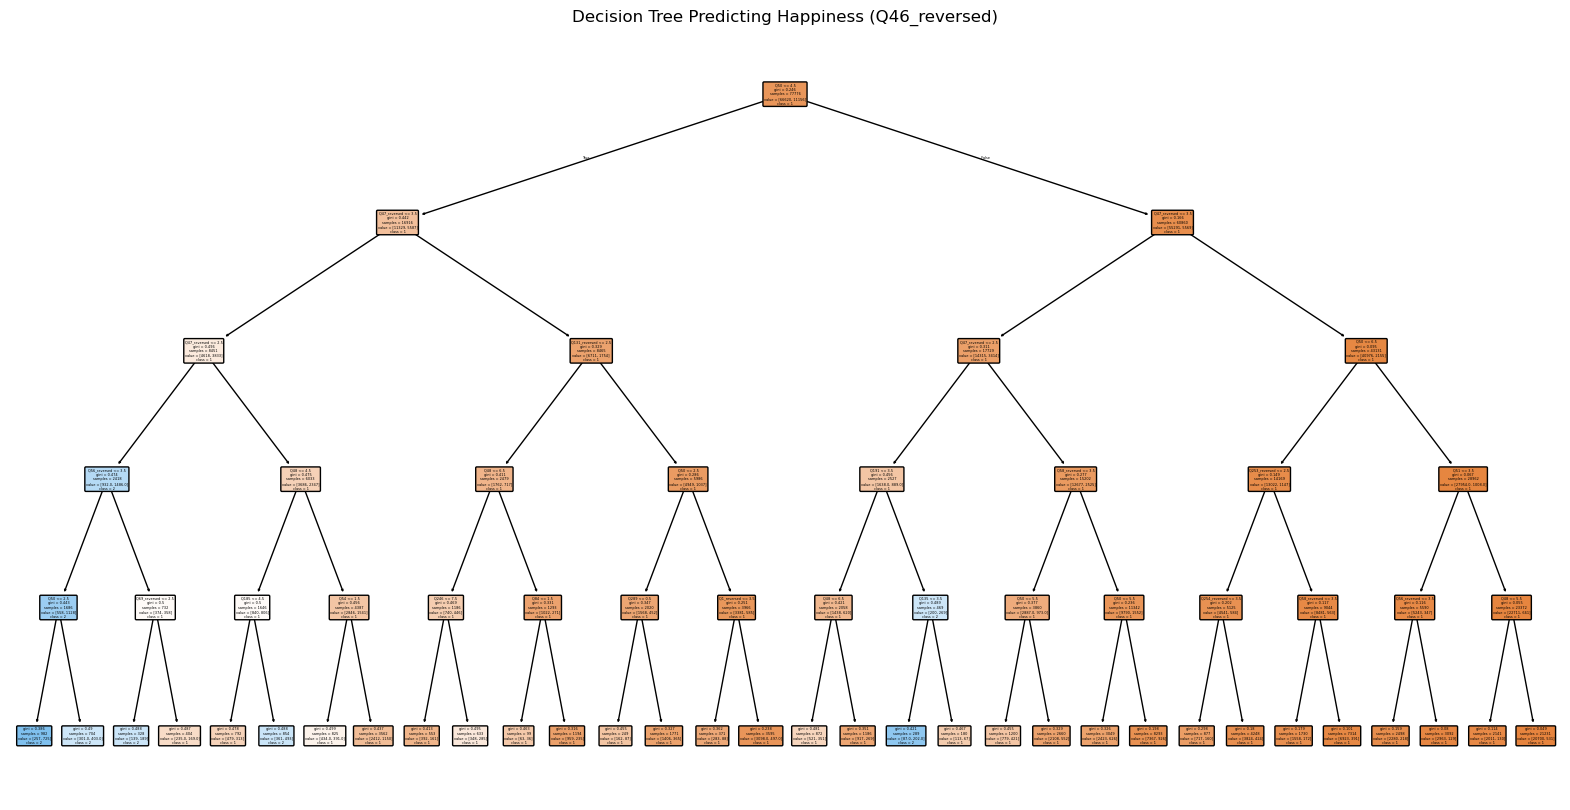

Financial Satisfaction                                  0.47
Self-Reported Health (Reversed: Higher = Healthier)     0.38
Freedom of Choice and Control                           0.03
Trust in Family (Reversed)                              0.02
Q191                                                    0.02
Feeling of Security Walking Alone at Night (Reversed)   0.01
Gone Without Necessary Clothing (Reversed)              0.01
Gone Without Cash Income                                0.01
Q185                                                    0.01
Importance of Family                                    0.01
dtype: float64


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['1', '2', '3', '4'], filled=True, rounded=True)
plt.title("Decision Tree Predicting Happiness (Q46_reversed)")
plt.show()

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
#print(importances[importances > 0].head(10))

importances_named = importances[importances > 0].head(10).rename(index=question_mapping)
print(importances_named)


In [41]:
#LOGISTIC REGRESSion

In [42]:


lr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)


lr_pipeline.fit(X_train, y_train)


y_pred = lr_pipeline.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance 
lr_model = lr_pipeline.named_steps['logisticregression']
scaler = lr_pipeline.named_steps['standardscaler']


scaled_features = X.columns
coeffs = pd.Series(lr_model.coef_[0], index=scaled_features)
coeffs_named = coeffs.rename(index=question_mapping).sort_values(key=np.abs, ascending=False)

print("\nTop Features Influencing 'Happy' (by coefficient magnitude):")
print(coeffs_named.head(20))



Logistic Regression Accuracy: 0.7638860316807241

 Classification Report:
               precision    recall  f1-score   support

       Happy       0.95      0.77      0.85     16705
     Unhappy       0.34      0.75      0.47      2739

    accuracy                           0.76     19444
   macro avg       0.65      0.76      0.66     19444
weighted avg       0.86      0.76      0.80     19444


Top Features Influencing 'Happy' (by coefficient magnitude):
Self-Reported Health (Reversed: Higher = Healthier)     -0.61
Financial Satisfaction                                  -0.46
Freedom of Choice and Control                           -0.25
Marital Status                                          -0.17
Feeling of Security Walking Alone at Night (Reversed)   -0.16
Gone Without Cash Income                                -0.13
Trust in Family (Reversed)                              -0.12
National Pride (Reversed)                               -0.11
Family Importance (Reversed)            

In [43]:
#KNN MODEL

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=7,weights='distance')
)

knn_pipeline.fit(X_train, y_train)
y_knn_pred = knn_pipeline.predict(X_test)

print("\nKNN Accuracy:", accuracy_score(y_test, y_knn_pred))
print("\nClassification Report:\n", classification_report(y_test, y_knn_pred))


KNN Accuracy: 0.8656655009257355

Classification Report:
               precision    recall  f1-score   support

       Happy       0.87      0.99      0.93     16705
     Unhappy       0.61      0.13      0.21      2739

    accuracy                           0.87     19444
   macro avg       0.74      0.56      0.57     19444
weighted avg       0.84      0.87      0.83     19444



In [45]:
#ENSEMBLE MODEL FOR BEST RESULTS

In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

xgb_model = make_pipeline(
    StandardScaler(),
    xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=3, random_state=42)
)

knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

xgb_knn_vote = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('knn', knn_model)
    ],
    voting='soft',
    weights=[2, 1]
)

xgb_knn_vote.fit(X_train, y_train)
y_vote_pred = xgb_knn_vote.predict(X_test)

print("XGBoost + KNN Soft Voting Accuracy:", accuracy_score(y_test, y_vote_pred))
print("\nClassification Report:\n", classification_report(y_test, y_vote_pred))


XGBoost + KNN Soft Voting Accuracy: 0.8769800452581773

Classification Report:
               precision    recall  f1-score   support

       Happy       0.91      0.96      0.93     16705
     Unhappy       0.59      0.40      0.48      2739

    accuracy                           0.88     19444
   macro avg       0.75      0.68      0.70     19444
weighted avg       0.86      0.88      0.87     19444

